In [1]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Tuple, Optional, List

# from sympy.abc import alpha
#
# from notebooks.ivf_resuscitation_splits import num_splits

In [2]:
os.chdir('..') # change working directory to root

In [3]:
from utilities import trauma_icu_resuscitation_funcs

/Users/larry/anaconda3/envs/ope_310_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mlflow_base_path = '<path_to_mlruns>/mlruns'
mlflow.set_tracking_uri(mlflow_base_path)

d3qn_ope_run_ids = {
    'fqe': '14130a6dbb054fada084ccfe2ec2c31a',
    'magic': '14130a6dbb054fada084ccfe2ec2c31a'
}

iql_ope_run_ids = {
    'fqe': '03af0f9dd90e48e3a1372a9c0c03be98',
    'magic': '03af0f9dd90e48e3a1372a9c0c03be98'
}

no_action_ope_run_ids = {
    'fqe': '5378fd699efe43379b7b83002c1e7ab0',
    'magic': '5378fd699efe43379b7b83002c1e7ab0'
}

random_action_ope_run_ids = {
    'fqe': 'faa29531a2cc4c33b36abd2043e0036c',
    'magic': 'faa29531a2cc4c33b36abd2043e0036c'
}

In [5]:
def get_metric_history(run_id: str, metric: str, tracking_uri: str, return_list: bool = False) -> Tuple[float, float] | List[float]:
    client = mlflow.MlflowClient(tracking_uri=tracking_uri)
    metric_history = client.get_metric_history(run_id, metric)
    vals = [metric.value for metric in metric_history]
    if return_list:
        return vals
    else:
        mean, std = np.mean(vals), np.std(vals)
        #result_dict = dict(mean=mean, std=std)
        #return result_dict
        return mean, std

def print_ope_result_table(ope_id: str, policy_run_id_dict: Dict[str, str], tracking_uri: str):
    print(f'{ope_id.upper()} Results:')
    for policy_id, run_id in policy_run_id_dict.items():
        mean, std = get_metric_history(run_id, ope_id, tracking_uri)
        print(f'{policy_id}: {mean:.5f} +/- {std:.5f}')

In [6]:
print_ope_result_table('fqe', {
    'd3qn': d3qn_ope_run_ids['fqe'],
    'iql': iql_ope_run_ids['fqe'],
    'no_action': no_action_ope_run_ids['fqe'],
    'random_action': random_action_ope_run_ids['fqe']
}, mlflow_base_path)

FQE Results:
d3qn: 6.09266 +/- 4.13516
iql: 10.88958 +/- 1.38747
no_action: 10.72125 +/- 1.53356
random_action: -21.22664 +/- 3.76327


In [7]:
print_ope_result_table('magic', {
    'd3qn': d3qn_ope_run_ids['magic'],
    'iql': iql_ope_run_ids['magic'],
    'no_action': no_action_ope_run_ids['magic'],
    'random_action': random_action_ope_run_ids['magic']
}, mlflow_base_path)

MAGIC Results:
d3qn: 6.65330 +/- 7.30599
iql: 5.13500 +/- 0.89610
no_action: 6.91249 +/- 1.27575
random_action: 10.01852 +/- 22.09990


In [8]:
gamma = 0.9
returns = list()
timesteps = list()
resus = list()
split_ = list()
for split in range(10):
    # load data
    (
        (_, _, _, _, _, _),
        (_, _, _, _, _, _),
        (test_states, test_actions, test_rewards, test_dones, test_next_states, test_missing_data)
    ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'ope', 'discrete')
    for traj_idx in range(test_states.size(0)):
        rewards = test_rewards[traj_idx]
        gammas = torch.full_like(rewards, gamma)
        gammas[0] = 1.0
        gammas = gammas.cumprod(0)
        G = (rewards * gammas).sum()
        returns.append(G.item())
        timesteps.append(test_missing_data[traj_idx].logical_not().sum().item())
        resus.append(rewards[test_missing_data[traj_idx].logical_not()].sum().item())
        split_.append(split)

df = pd.DataFrame.from_dict({
    'return': returns,
    'timesteps': timesteps,
    'resus': resus,
    'split': split_
})
df.head()

Data Split: 100%|██████████| 3/3 [00:25<00:00,  8.58s/ split]


,return,timesteps,resus,split
0,-8.374102,41,60.0,0
1,-5.803276,32,69.0,0
2,-8.193447,40,61.0,0
3,-10.417453,52,-151.0,0
4,89.000000,2,99.0,0


In [9]:
df[df['split'] == 0]['timesteps'].value_counts()

timesteps
2     176
52     61
51     59
53     40
50     32
     ... 
63      1
62      1
5       1
67      1
71      1
Name: count, Length: 64, dtype: int64

In [98]:
monte_carlo_resus_value_sample(0.7, test_rewards)

(19.525040792913934, 0.701)

In [91]:
v = torch.multinomial((resus_counts / resus_counts.sum().float()), n_sample, replacement=True)
resus_timesteps[v]

tensor([ 2,  2, 34,  ..., 16,  2, 10])

In [10]:
def monte_carlo_resus_value_sample(pct_resus: float, test_rewards_, n_sample: int = 10000) -> Tuple[float, float]:
    n_timesteps = test_rewards_.abs().argmax(dim=-1) + 1
    resus = test_rewards_[torch.arange(test_rewards_.size(0)), n_timesteps-1] > 0
    resus_timesteps, resus_counts = n_timesteps[resus].unique(return_counts=True)
    non_resus_timesteps, non_resus_counts = n_timesteps[~resus].unique(return_counts=True)
    sampled_resus = np.random.choice([-1, 1], n_sample, replace=True, p=[1-pct_resus, pct_resus])
    try:
        sampled_resus_timesteps = torch.multinomial((resus_counts / resus_counts.sum().float()), n_sample, replacement=True).numpy()
        sampled_resus_timesteps = resus_timesteps[sampled_resus_timesteps]
        sampled_non_resus_timesteps = torch.multinomial((non_resus_counts / non_resus_counts.sum().float()), n_sample, replacement=True).numpy()
        sampled_non_resus_timesteps = non_resus_timesteps[sampled_non_resus_timesteps]
        # sampled_resus_timesteps = np.random.choice(resus_timesteps.numpy(), n_sample, replace=True, p=(resus_counts / resus_counts.sum().float()))
        # sampled_non_resus_timesteps = np.random.choice(non_resus_timesteps.numpy(), n_sample, replace=True, p=(non_resus_counts / non_resus_counts.sum().item()))
    except ValueError as ve:
        print(f'Resus: {(resus_counts / resus_counts.sum().float().item()).sum()}')
        print(f'Non-Resus: {(non_resus_counts / non_resus_counts.sum().item()).sum()}')
        raise ve
    sampled_timesteps = np.where(sampled_resus == 1, sampled_resus_timesteps, sampled_non_resus_timesteps)
    gammas = np.logspace(0, 71, 72, base=gamma)
    rewards = np.full((n_sample, 72), -1)
    rewards[np.arange(n_sample), sampled_timesteps-1] = sampled_resus * 100
    zero_mask = np.expand_dims(sampled_timesteps, -1).repeat(72, axis=-1) <= np.expand_dims(np.arange(0, 72, 1), 0).repeat(n_sample, axis=0)
    rewards[zero_mask] = 0
    returns = (rewards * gammas).sum(-1)
    value = returns.mean()
    n_resus_ = (sampled_resus == 1).sum()
    resus_pct = n_resus_ / n_sample
    return value, resus_pct

num_itrs = 1000
monte_carlo_values = list()
monte_carlo_resus_pct = list()
for split in range(10):
    (
        (_, _, _, _, _, _),
        (_, _, _, _, _, _),
        (test_states, test_actions, test_rewards, test_dones, test_next_states, test_missing_data)
    ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'ope', 'discrete')
    for i in tqdm(range(num_itrs)):
        cur_resus_pct = np.round(i / num_itrs, decimals=2)
        v, pct = monte_carlo_resus_value_sample(cur_resus_pct, test_rewards)
        monte_carlo_values.append(v)
        monte_carlo_resus_pct.append(pct)
monte_carlo_value_df = pd.DataFrame.from_dict({
    'value': monte_carlo_values,
    'resus_pct': monte_carlo_resus_pct
})
monte_carlo_value_df.head()

100%|██████████| 1000/1000 [00:03<00:00, 268.35it/s]


,value,resus_pct
0,-10.402025,0.0
1,-10.402715,0.0
2,-10.402247,0.0
3,-10.403088,0.0
4,-10.402474,0.0


In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X=monte_carlo_value_df['value'].values.reshape(-1, 1), y=monte_carlo_value_df['resus_pct'].values.reshape(-1, 1))

LinearRegression()

In [12]:
lr.coef_, lr.intercept_

(array([[0.02379356]]), array([0.24765604]))

In [13]:
monte_carlo_value_df.shape[0]

10000

In [14]:
def compute_95_pct_confidence_interval(x_: np.ndarray, y_: np.ndarray, lr_: LinearRegression) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    s = np.sqrt(np.sum(np.power(y_ - y_.mean(), 2)) / (y_.shape[0] - 2))
    slope_se = s / np.sqrt(np.sum(np.power(x_ - x_.mean(), 2)))
    intercept_se = s * np.sqrt(1 / y_.shape[0] + np.power(x_.mean(), 2) / np.sum(np.power(x_ - x_.mean(), 2)))
    t_val = 1.960 # 95% confidence interval for 10000 samples
    slope_ci = t_val * slope_se
    intercept_ci = t_val * intercept_se
    return (slope_se + slope_ci, slope_se - slope_ci), (intercept_se + intercept_ci, intercept_se - intercept_ci)

compute_95_pct_confidence_interval(monte_carlo_value_df['value'].values, monte_carlo_value_df['resus_pct'].values, lr)

((0.00070457693516316, -0.0002285114384312951),
 (0.01134320399423355, -0.003678876971102773))

In [15]:
lr_x = np.linspace(monte_carlo_value_df['value'].min(), monte_carlo_value_df['value'].max(), 100)
lr_y = lr.predict(lr_x.reshape(-1, 1))

In [16]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(monte_carlo_value_df['value'], monte_carlo_value_df['resus_pct'])
x_range = np.linspace(monte_carlo_value_df['value'].min(), monte_carlo_value_df['value'].max(), 100)
y_fit = slope * x_range + intercept
t_value = stats.t.ppf(0.975, df=monte_carlo_value_df.shape[0]-2) # 95% confidence interval
slope_ci = t_value * std_err
upper_bound = y_fit + slope_ci
lower_bound = y_fit - slope_ci

In [17]:
slope, intercept, r_value, p_value, std_err

(0.023793557441688352,
 0.2476560426063626,
 0.9996917364418032,
 0.0,
 5.909889089134168e-06)

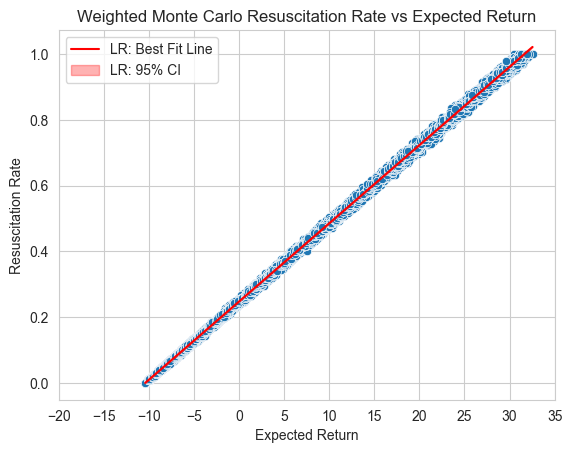

In [39]:
ax = sns.scatterplot(x='value', y='resus_pct', data=monte_carlo_value_df)
#ax.plot(lr_x, lr_y, color='red', label='LR: Best Fit Line')
ax.plot(x_range, y_fit, color='red', label='LR: Best Fit Line')
ax.fill_between(x_range, lower_bound, upper_bound, color='red', alpha=0.3, label='LR: 95% CI')
_ = ax.set_xticks(range(-20, 36, 5))
ax.set_title('Weighted Monte Carlo Resuscitation Rate vs Expected Return')
ax.set_xlabel('Expected Return')
ax.set_ylabel('Resuscitation Rate')
ax.legend()

In [20]:
monte_carlo_value_df['value'].min()

-10.40509844911618

In [21]:
monte_carlo_value_df['value'].max()

32.543921414077104

In [22]:
(
    (_, _, _, _, _, _),
    (_, _, _, _, _, _),
    (test_states, test_actions, test_rewards, test_dones, test_next_states, test_missing_data)
) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(1, 'ope', 'discrete')
test_rewards.abs().argmax(dim=-1)

Data Split: 100%|██████████| 3/3 [00:13<00:00,  4.54s/ split]


tensor([52, 52, 51, 59,  1, 59,  1, 51, 33, 44, 49, 14,  1, 55, 63, 51,  1, 24,
         1, 52,  1,  7, 44,  1, 38, 17,  8,  9, 29, 46, 31, 28, 49,  1,  1, 31,
         1, 53, 16,  1,  1, 51,  1, 25, 12, 21,  1, 22,  1, 50,  1, 50, 53,  1,
        11,  1, 53, 46,  1,  1, 54,  1,  1,  1, 41, 54, 51, 21, 45, 25, 55,  3,
        41,  1, 27,  1,  7, 14, 49, 40,  1, 33, 30, 50, 10,  1, 15, 22, 54,  1,
         4, 35, 34, 10,  1,  1, 15, 51,  1, 55, 52, 46,  8, 36, 51, 46,  7, 42,
        70,  1, 39,  1, 12, 12, 49, 51, 10, 50, 22, 12, 55, 37, 51, 22, 37, 50,
        53, 57,  1, 52, 49, 30,  1,  1, 38, 53,  5, 49, 48,  1, 44,  1, 41, 26,
        12, 38, 51, 47,  8, 52, 50, 49, 50,  4, 30, 35, 30, 19, 27, 32, 14,  1,
         9, 49,  1, 52, 51, 54, 51, 50, 39, 52, 18, 16, 50, 25,  1, 60, 49, 53,
        41,  4, 55, 28,  1, 16, 53, 13,  7,  8, 47, 53, 19, 40,  1,  1, 51, 51,
        52, 31, 55,  1, 21,  1, 37, 56, 26, 49, 33,  6, 28, 46, 51,  1, 40, 49,
         1,  1, 51,  1, 42, 38, 20, 24, 

In [23]:
n_timesteps = test_rewards.abs().argmax(dim=-1) + 1
resus = test_rewards[torch.arange(test_rewards.size(0)), n_timesteps-1] > 0
resus_timesteps, resus_counts = n_timesteps[resus].unique(return_counts=True)
non_resus_timesteps, non_resus_counts = n_timesteps[~resus].unique(return_counts=True)
t_step_dist_df = pd.DataFrame.from_dict({
    'timestep': resus_timesteps.tolist() + non_resus_timesteps.tolist(),
    'count': resus_counts.tolist() + non_resus_counts.tolist(),
    'resus': [True for _ in range(resus_timesteps.size(0))] + [False for _ in range(non_resus_timesteps.size(0))]
})
t_step_dist_df.head()
#print(f'Resus Timesteps: {n_timesteps[resus].unique(return_counts=True)}')
#print(f'Non-Resus Timesteps: {n_timesteps[~resus].unique(return_counts=True)}')

,timestep,count,resus
0,2,176,True
1,4,3,True
2,5,5,True
3,6,3,True
4,7,15,True


Text(0.5, 1.0, 'Distribution of Timesteps for Resuscitation and Non-Resuscitation Trajectories for Split 1')

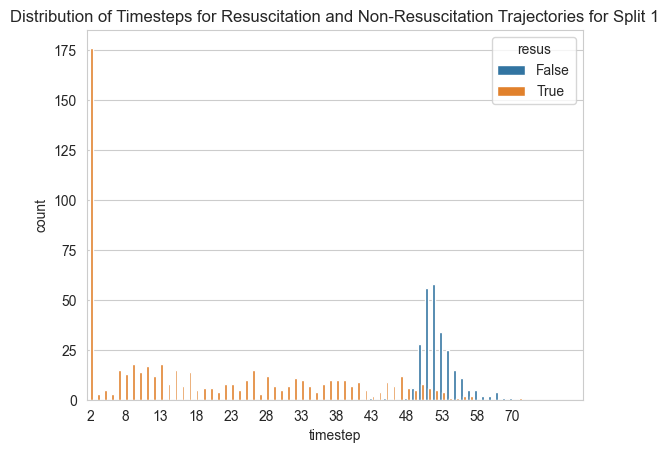

In [24]:
ax = sns.barplot(x='timestep', y='count', hue='resus', data=t_step_dist_df)
ax.set_xticks(range(0, 72, 5))
ax.set_title('Distribution of Timesteps for Resuscitation and Non-Resuscitation Trajectories for Split 1')

In [25]:
gammas = torch.logspace(0, 71, 72, base=gamma).unsqueeze(0).repeat(test_rewards.shape[0], 1)
(test_rewards * gammas).sum(-1).mean()

tensor(19.1131)

In [26]:
gamma = 0.9
behavior_policy_values = list()
num_patients = list()
num_non_resus = list()
num_resus = list()
for split in range(10):
    # load data
    (
        (_, _, _, _, _, _),
        (_, _, _, _, _, _),
        (test_states, test_actions, test_rewards, test_dones, test_next_states, test_missing_data)
    ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'ope', 'discrete')
    returns = 0.0
    # NOTE: This is very inefficient - we could compute the returns in a single pass - but not worth the effort
    for i in range(test_states.size(0)):
        current_return = 0.0
        current_gamma = 1.0 # first reward is undiscounted
        for t in range(test_states.size(1)):
            reward = test_rewards[i, t].item()
            current_return += current_gamma * reward
            current_gamma *= gamma
            if test_dones[i, t].item():
                break # done with this trajectory
        returns += current_return
    returns /= test_states.size(0) # mean value
    behavior_policy_values.append(returns)
    cur_num_patients = test_states.size(0)
    num_patients.append(cur_num_patients)
    n_resus = n_non_resus = 0
    for traj_idx in range(test_rewards.size(0)):
        final_r = test_rewards[traj_idx][test_missing_data[traj_idx].logical_not()][-1]
        if final_r > 0:
            n_resus += 1
        else:
            n_non_resus += 1
    num_non_resus.append(n_non_resus)
    num_resus.append(n_resus)
    assert cur_num_patients == num_non_resus[-1] + num_resus[-1], 'Number of patients does not match number of deaths and survivors'
behavior_policy_values, num_patients, num_non_resus, num_resus

Data Split: 100%|██████████| 3/3 [00:25<00:00,  8.40s/ split]


([19.086565987139082,
  19.113141350029498,
  18.92000397987849,
  19.243751160725605,
  18.9787141542914,
  19.06294190030447,
  19.22298210363117,
  19.03786922370288,
  19.287718604805185,
  19.25410193856553],
 [861, 861, 861, 861, 861, 861, 861, 861, 861, 861],
 [256, 256, 256, 256, 256, 256, 256, 256, 256, 256],
 [605, 605, 605, 605, 605, 605, 605, 605, 605, 605])

In [27]:
print(f'Behavior Policy Value: {np.mean(behavior_policy_values):.5f} +/- {np.std(behavior_policy_values):.5f}')

Behavior Policy Value: 19.12078 +/- 0.11965


In [28]:
# Demonstrate expected return vs mortality rate has a linear relationship
for b_policy_val, n_patients, n_non_resus, n_resus in zip(behavior_policy_values, num_patients, num_non_resus, num_resus):
    print(f'Behavior Policy Value: {b_policy_val:.5f}, Num Patients: {n_patients}, Num Non-Resus: {n_non_resus}, Num Resus: {n_resus}')
    print(f'Non-Resuscitation Rate: {n_non_resus / n_patients:.5f}, Resuscitation Rate: {n_resus / n_patients:.5f}')
    #computed_b_val = 15 * (n_resus - n_non_resus) / n_patients
    #print(f'Computed Behavior Policy Value: {computed_b_val:.5f}')
    print('---')

Behavior Policy Value: 19.08657, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
Non-Resuscitation Rate: 0.29733, Resuscitation Rate: 0.70267
---
Behavior Policy Value: 19.11314, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
Non-Resuscitation Rate: 0.29733, Resuscitation Rate: 0.70267
---
Behavior Policy Value: 18.92000, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
Non-Resuscitation Rate: 0.29733, Resuscitation Rate: 0.70267
---
Behavior Policy Value: 19.24375, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
Non-Resuscitation Rate: 0.29733, Resuscitation Rate: 0.70267
---
Behavior Policy Value: 18.97871, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
Non-Resuscitation Rate: 0.29733, Resuscitation Rate: 0.70267
---
Behavior Policy Value: 19.06294, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
Non-Resuscitation Rate: 0.29733, Resuscitation Rate: 0.70267
---
Behavior Policy Value: 19.22298, Num Patients: 861, Num Non-Resus: 256, Num Resus: 605
N

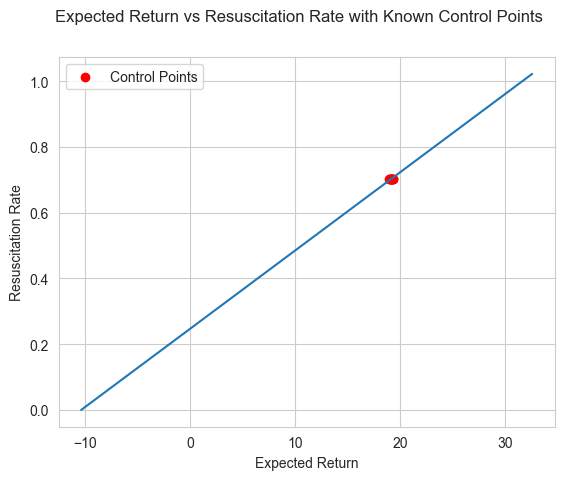

In [40]:
behavior_policy_resus = [n_resus / n_patients for n_resus, n_patients in zip(num_resus, num_patients)]
sns.lineplot(x=x_range, y=y_fit)
plt.scatter(behavior_policy_values, behavior_policy_resus, color='red', label='Control Points')
plt.suptitle('Expected Return vs Resuscitation Rate with Known Control Points')
plt.legend()
plt.xlabel('Expected Return')
plt.ylabel('Resuscitation Rate')
plt.show()

In [30]:
max_return_ = (1.0 - intercept) / slope
min_return_ = (0.0 - intercept) / slope

In [31]:
def compute_resus_rate_from_expected_return(expected_return: float, slope_: float, intercept_: float) -> float:
    return expected_return * slope_ + intercept_

def clip_return(return_val: float, min_: float, max_: float) -> float:
    return max(min_, min(max_, return_val))

In [32]:
d3qn_fqe = [clip_return(v, min_return_, max_return_) for v in get_metric_history(d3qn_ope_run_ids['fqe'], 'fqe', mlflow_base_path, return_list=True)]
d3qn_magic = [clip_return(v, min_return_, max_return_) for v in get_metric_history(d3qn_ope_run_ids['magic'], 'magic', mlflow_base_path, return_list=True)]
iql_fqe = [clip_return(v, min_return_, max_return_) for v in get_metric_history(iql_ope_run_ids['fqe'], 'fqe', mlflow_base_path, return_list=True)]
iql_magic = [clip_return(v, min_return_, max_return_) for v in get_metric_history(iql_ope_run_ids['magic'], 'magic', mlflow_base_path, return_list=True)]
no_action_fqe = [clip_return(v, min_return_, max_return_) for v in get_metric_history(no_action_ope_run_ids['fqe'], 'fqe', mlflow_base_path, return_list=True)]
no_action_magic = [clip_return(v, min_return_, max_return_) for v in get_metric_history(no_action_ope_run_ids['magic'], 'magic', mlflow_base_path, return_list=True)]
random_action_fqe = [clip_return(v, min_return_, max_return_) for v in get_metric_history(random_action_ope_run_ids['fqe'], 'fqe', mlflow_base_path, return_list=True)]
random_action_magic = [clip_return(v, min_return_, max_return_) for v in get_metric_history(random_action_ope_run_ids['magic'], 'magic', mlflow_base_path, return_list=True)]

In [33]:
d3qn_fqe_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in d3qn_fqe]
d3qn_magic_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in d3qn_magic]
iql_fqe_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in iql_fqe]
iql_magic_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in iql_magic]
no_action_fqe_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in no_action_fqe]
no_action_magic_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in no_action_magic]
random_action_fqe_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in random_action_fqe]
random_action_magic_mortalities = [compute_resus_rate_from_expected_return(val, slope, intercept) for val in random_action_magic]

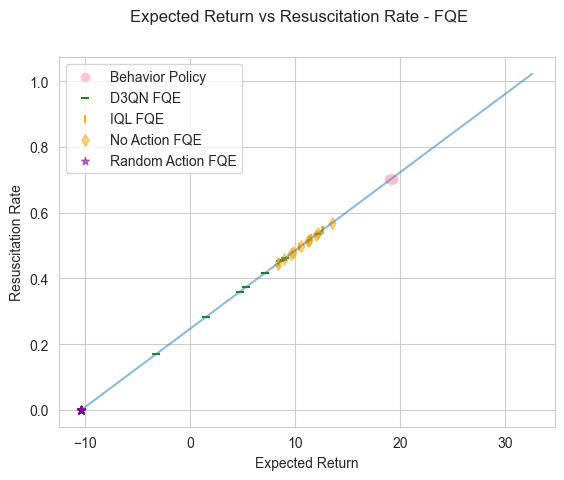

In [38]:
ax = sns.lineplot(x=x_range, y=y_fit, alpha=0.5)
#ax.lines[0].set_linestyle('--')
plt.scatter(behavior_policy_values, behavior_policy_resus, color='pink', label='Behavior Policy', alpha=0.9, marker='o')
plt.scatter(d3qn_fqe, d3qn_fqe_mortalities, color='green', label='D3QN FQE', alpha=0.9, marker='_')
plt.scatter(iql_fqe, iql_fqe_mortalities, color='orange', label='IQL FQE', alpha=0.9, marker='|')
plt.scatter(no_action_fqe, no_action_fqe_mortalities, color='orange', label='No Action FQE', alpha=0.5, marker='d')
plt.scatter(random_action_fqe, random_action_fqe_mortalities, color='purple', label='Random Action FQE', alpha=0.5, marker='*')
plt.suptitle('Expected Return vs Resuscitation Rate - FQE')
plt.legend()
plt.xlabel('Expected Return')
plt.ylabel('Resuscitation Rate')
plt.show()

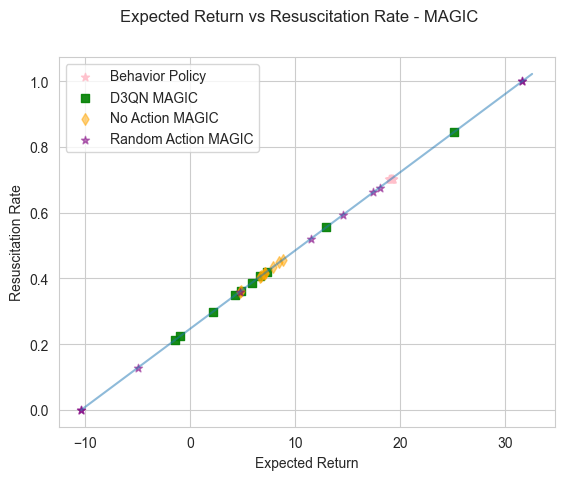

In [35]:
sns.lineplot(x=x_range, y=y_fit, alpha=0.5)
plt.scatter(behavior_policy_values, behavior_policy_resus, color='pink', label='Behavior Policy', alpha=0.9, marker='*')
plt.scatter(d3qn_magic, d3qn_magic_mortalities, color='green', label='D3QN MAGIC', alpha=0.9, marker='s')
#plt.scatter(iql_magic, iql_magic_mortalities, color='blue', label='IQL MAGIC', alpha=0.9, marker='v')
plt.scatter(no_action_magic, no_action_magic_mortalities, color='orange', label='No Action MAGIC', alpha=0.5, marker='d')
plt.scatter(random_action_magic, random_action_magic_mortalities, color='purple', label='Random Action MAGIC', alpha=0.5, marker='*')
plt.suptitle('Expected Return vs Resuscitation Rate - MAGIC')
plt.legend()
plt.xlabel('Expected Return')
plt.ylabel('Resuscitation Rate')
plt.show()

In [36]:
print(f'Behavior Policy Resuscitation Rate: {np.mean(behavior_policy_resus):.5f} +/- {np.std(behavior_policy_resus):.5f}')
print(f'D3QN FQE Resuscitation Rate: {np.mean(d3qn_fqe_mortalities):.5f} +/- {np.std(d3qn_fqe_mortalities):.5f}')
print(f'D3QN MAGIC Resuscitation Rate: {np.mean(d3qn_magic_mortalities):.5f} +/- {np.std(d3qn_magic_mortalities):.5f}')
print(f'IQL FQE Resuscitation Rate: {np.mean(iql_fqe_mortalities):.5f} +/- {np.std(iql_fqe_mortalities):.5f}')
print(f'IQL MAGIC Resuscitation Rate: {np.mean(iql_magic_mortalities):.5f} +/- {np.std(iql_magic_mortalities):.5f}')
print(f'No Action FQE Resuscitation Rate: {np.mean(no_action_fqe_mortalities):.5f} +/- {np.std(no_action_fqe_mortalities):.5f}')
print(f'No Action MAGIC Resuscitation Rate: {np.mean(no_action_magic_mortalities):.5f} +/- {np.std(no_action_magic_mortalities):.5f}')
print(f'Random Action FQE Resuscitation Rate: {np.mean(random_action_fqe_mortalities):.5f} +/- {np.std(random_action_fqe_mortalities):.5f}')
print(f'Random Action MAGIC Resuscitation Rate: {np.mean(random_action_magic_mortalities):.5f} +/- {np.std(random_action_magic_mortalities):.5f}')

Behavior Policy Resuscitation Rate: 0.70267 +/- 0.00000
D3QN FQE Resuscitation Rate: 0.39262 +/- 0.09839
D3QN MAGIC Resuscitation Rate: 0.40596 +/- 0.17384
IQL FQE Resuscitation Rate: 0.50676 +/- 0.03301
IQL MAGIC Resuscitation Rate: 0.36984 +/- 0.02132
No Action FQE Resuscitation Rate: 0.50275 +/- 0.03649
No Action MAGIC Resuscitation Rate: 0.41213 +/- 0.03035
Random Action FQE Resuscitation Rate: 0.00000 +/- 0.00000
Random Action MAGIC Resuscitation Rate: 0.49411 +/- 0.34982


In [41]:
print(f'Behavior Policy Expected Value: {np.mean(behavior_policy_values):.5f} +/- {np.std(behavior_policy_values):.5f}')
print(f'D3QN FQE Expected Value: {np.mean(d3qn_fqe):.5f} +/- {np.std(d3qn_fqe):.5f}')
print(f'D3QN MAGIC Expected Value: {np.mean(d3qn_magic):.5f} +/- {np.std(d3qn_magic):.5f}')
print(f'IQL FQE Expected Value: {np.mean(iql_fqe):.5f} +/- {np.std(iql_fqe):.5f}')
print(f'IQL MAGIC Expected Value: {np.mean(iql_magic):.5f} +/- {np.std(iql_magic):.5f}')
print(f'No Action FQE Expected Value: {np.mean(no_action_fqe):.5f} +/- {np.std(no_action_fqe):.5f}')
print(f'No Action MAGIC Expected Value: {np.mean(no_action_magic):.5f} +/- {np.std(no_action_magic):.5f}')
print(f'Random Action FQE Expected Value: {np.mean(random_action_fqe):.5f} +/- {np.std(random_action_fqe):.5f}')
print(f'Random Action MAGIC Expected Value: {np.mean(random_action_magic):.5f} +/- {np.std(random_action_magic):.5f}')

Behavior Policy Expected Value: 19.12078 +/- 0.11965
D3QN FQE Expected Value: 6.09266 +/- 4.13516
D3QN MAGIC Expected Value: 6.65330 +/- 7.30599
IQL FQE Expected Value: 10.88958 +/- 1.38747
IQL MAGIC Expected Value: 5.13500 +/- 0.89610
No Action FQE Expected Value: 10.72125 +/- 1.53356
No Action MAGIC Expected Value: 6.91249 +/- 1.27575
Random Action FQE Expected Value: -10.40853 +/- 0.00000
Random Action MAGIC Expected Value: 10.35798 +/- 14.70214
